# 『採点者の方へ』
「Colab データインストール 」部分削除し
jupyter notebook等で該当のデータを読み込む形に直して利用ください。

# Colab データインストール

In [0]:
# 以下を実行すると、認証情報を取得するための許可を求められるので、許可してトークンを発行し、テキストボックスに貼り付ける。
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [0]:
# Colabにおいてデータを読みこむ。グーグルドライブをマウントします。その為に必要なパッケージを取得しておく。
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


In [3]:
# 以下実行により、今度は google-drive-ocamlfuse によるアクセスの許可を聞かれる。これも許可する。
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [4]:
# 今回は指定したフォルダのみマウントする
!cp -f ~/.gdfuse/default/config config
!sed -i -e "s/^root_folder=$/root_folder=1FwGdPnKlcYYRe1mZGE5Ci-PWlIY8k5J7/" config
# 上記が正常に終われば、ようやくマウントが可能となる。
!mkdir -p drive
!google-drive-ocamlfuse -config ./config -cc drive
!ls drive

Clearing cache...done
Colab dataマウントテンプレ.ipynb  dataset      EDA-2.ipynb     kernel_2.ipynb
compare-deeplibs.ipynb		  EDA-1.ipynb  kernel_1.ipynb  tests.ipynb


In [5]:
# これ以降はターミナルと同様にディレクトリを扱える
cd drive/dataset

/content/drive/dataset


In [6]:
ls

House Prices_data/  Instacart Market Basket/


In [7]:
cd Instacart Market Basket

/content/drive/dataset/Instacart Market Basket


In [8]:
ls

aisles.csv       order_products__prior.csv  orders.csv    sample_submission.csv
departments.csv  order_products__train.csv  products.csv


# EDA-2 課題

このノートブックでは、与えられたデータセットに関する基本情報を試してみましょう。このコンペのデータセットは、時間の経過とともに顧客の注文を記述した記録とその関係です。

目的：

競争の目標は、どの製品が次の顧客に選ばれるか予測することです。このデータセットは匿名化されており、Instacartの200,000人以上のユーザーから300万件を超えるサンプルを提供しています。

各ユーザーに対して、4つの注文と100の注文が与えられ、各注文で購入された一連の製品がリストされてます

必要なモジュールをインポートすることから始めましょう。

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
# sns.color_palette() = Seabornのカラーパレット [https://qiita.com/SaitoTsutomu/items/c79c9973a92e1e2c77a7]

%matplotlib inline
# %matplotlib inline = jupyter notebookでmatplotlibを表示させるおまじない。colabでは不要。実はここでのライブラリも全てデフォルトでインストールされてるので本当は不要。

pd.options.mode.chained_assignment = None  # default='warn'
# http://d.hatena.ne.jp/yasuhallabo/20171114

私たちが探索的分析に深く入る前に、与えられたファイルについてもう少し詳しくお聞かせください。それをよりよく理解するためには、最初にすべてのファイルをデータフレームオブジェクトとして読み込み、上の数行を見てみましょう。

In [0]:
order_products_train_df = pd.read_csv("order_products__train.csv")
order_products_prior_df = pd.read_csv("order_products__prior.csv")
orders_df = pd.read_csv("orders.csv")
products_df = pd.read_csv("products.csv")
aisles_df = pd.read_csv("aisles.csv")
departments_df = pd.read_csv("departments.csv")

In [11]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [12]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [13]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


orders_dfにほとんどすべての情報が含まれていそうです。
order_products_prior_dfとorder_products_train_dfはカラムが全く同じです。
2つのファイルの違いは何でしょうか？
今回は過去の購入履歴から次の購入品を予測します。つまり、priorファイルにはtrain, test両方の購入履歴が含まれており、order_products_train_dfは学習用の正解データということです。

最初に、3つのセットのそれぞれの行の数を取得しましょう。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


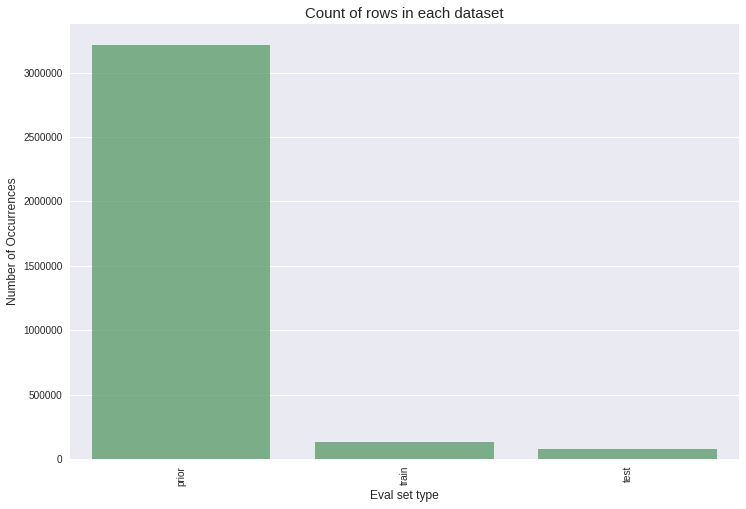

In [14]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

複数のpriorからtrain, testを予測するので、priorが圧倒的に多いことがわかります。
まずはprior, train, testにそれぞれ何人userがいるのか見ましょう。
orders_dfをeval_setでグループ化し、各グループ内でuser_idを重複無しでcountします。

In [15]:
def get_unique_count(x):
    return len(np.unique(x))
#np.unique = array変数の要素の重複をなくしたものを返します。
  
cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
# aggregateはgroupbyしたグループに様々な関数を適応するメソッドです。aggregate()で集計
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

合計206,209人の顧客がいる。そのうち、131,209人の顧客の最後の購入が訓練データとして与えられ、残りの75,000人の顧客を予測する必要があります。(testデータになる)


今度は、顧客の4から100件の注文が与えられたという主張を検証しましょう。
userの登場回数は何回でしょうか。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


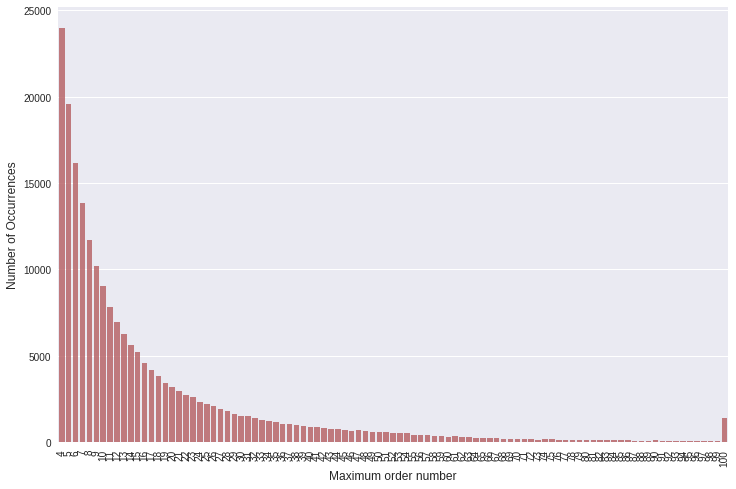

In [16]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
#reset_index() = データを削除したり並べ替えたあとにインデックスを振り直すメゾット

cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

最小で4回、最大で100回商品を購入しています。

おそらく週末の注文は多そうです。曜日情報で注文数を切り分けて見ましょう。曜日情報は'order_dow'です。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


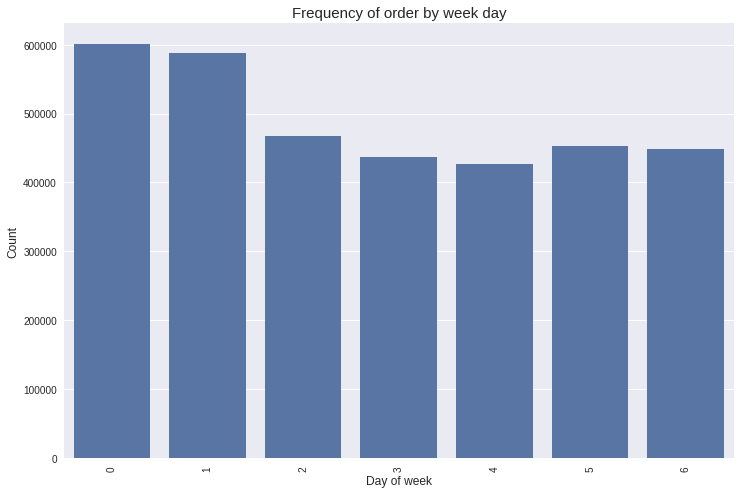

In [17]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
# countplotメゾット = Y軸の数値を、X軸に該当するデータのカウントが出来ます。

plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

見た感じ、day of week = 0, 1がそれぞれ土曜、日曜に当たるようです。
平日での注文数はわずかな違いがあります。
同様に、時間で区切って注文数を見ていきましょう。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


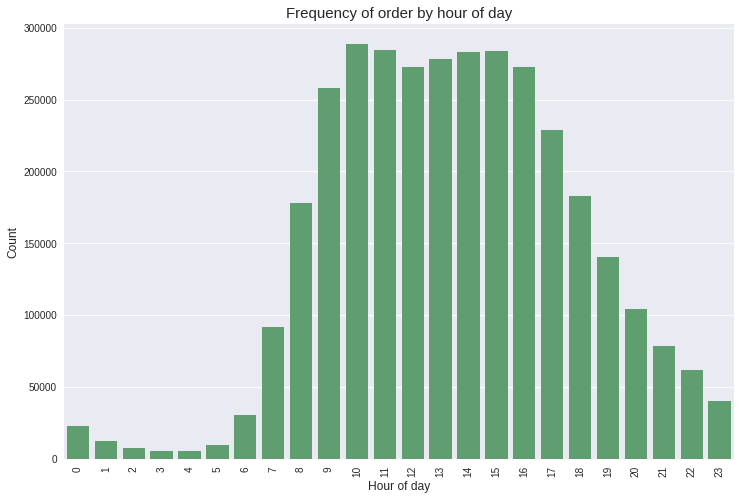

In [18]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

土日込みでチェックしているせいか、最も注文が多い時間は昼間(午前10時と午後15時)となっています。朝の注文は少なく、夜は時間が遅くなるごとに注文数が減少していきます。

曜日と時間の注文数への関係性は深そうです。それらをヒートマップで可視化して見ます。

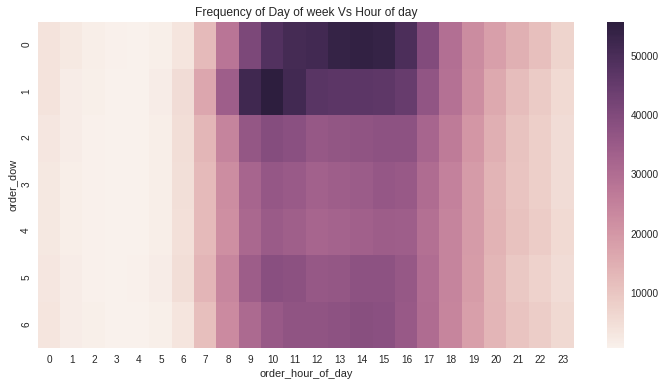

In [19]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

# pivotはDataFrameの２軸だけに着目し、新しいフレームを作成します。

平日と休日では明らかな違いがあります。
平日は曜日ごとの違いがあまりなく、午前9時から午後16時までが注文数が多くなります。
休日は土日で顕著に異なります。土曜日は昼過ぎの注文が最も多く、遅い時間まで注文が続きます。日曜は午前中の注文が最も多いです。

次に注文の時間間隔を見ていきます。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


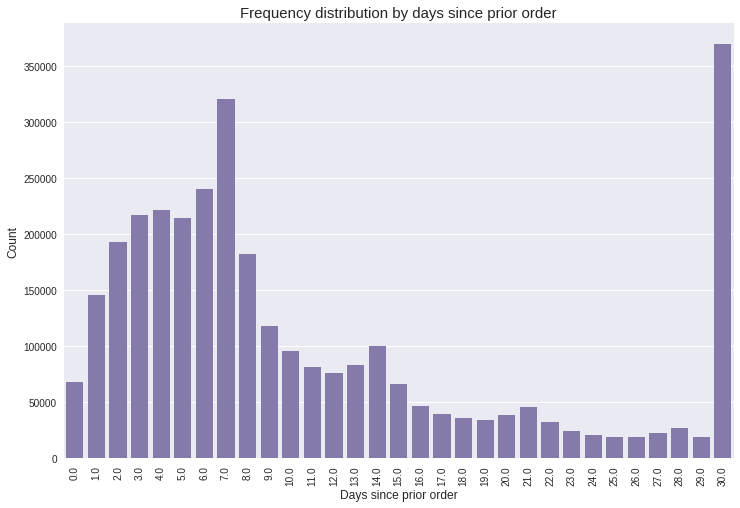

In [20]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

前の注文から次の注文までの日数は'days_since_prior_order'で示されます。
7日と30日がピークで、7日を過ぎたあたりから14日、21日、28日と１週間ごとに周期性が存在しています。

時間と注文数の関係性が明らかになったところで、今回のコンペで予測対象となる再購入について見ましょう。

In [21]:
# percentage of re-orders in prior set #
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.5896974667922161

In [22]:
# percentage of re-orders in train set #
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

prior, train共に、再購入した割合は59%前後であることがわかります。
残りの40%近くは再購入ではない注文だったということなので、おそらく再購入が含まれていない注文(order_id)が含まれているはずです。



In [23]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [24]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


1    0.93444
0    0.06556
Name: reordered, dtype: float64

priorでは再購入していないオーダーは12%です。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


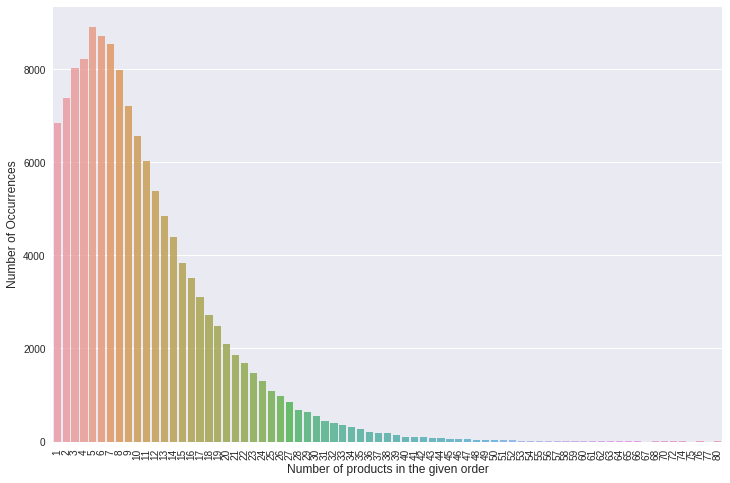

In [25]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

order_idをカウントするのではなく、add_to_cart_orderの最大値から一度の注文数を求めています。
最も多いのが5個の同時注文で、そこからポアソン分布のようなright tailedの減少を見せています。

ちなみに。
1年あたり平均0.61人の兵士が馬に蹴られて死ぬ軍隊において、「1年に何人の兵士が馬に蹴られて死ぬかの確率の分布」を求める。
これが、歴史上で初めてポアソン分布が使われた事例だと言われています。

In [26]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [27]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [28]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


商品に関するデータは、products, aisles, departmentsに分散しています。
まずはこれらの情報を結合していきます。

In [29]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


最も注文されている商品名は何でしょうか。

In [30]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


トップはバナナ、それ以降はフルーツを中心として様々な食料品が並びます。また、ほとんどすべてオーガニック商品となっています。

『商品カテゴリ(aisle)別分析』

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


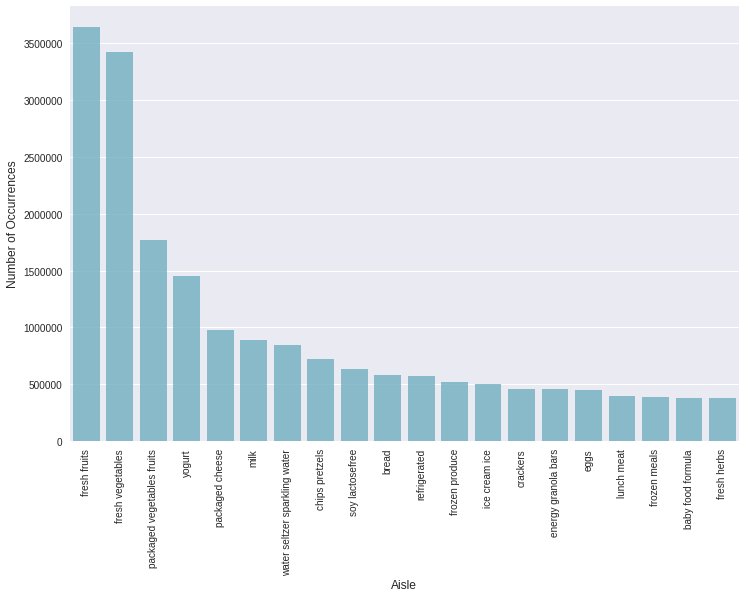

In [31]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

最も多い2つは、生鮮果物と生鮮野菜です。

部門別分析

商品の部門(department)について見ていきましょう。

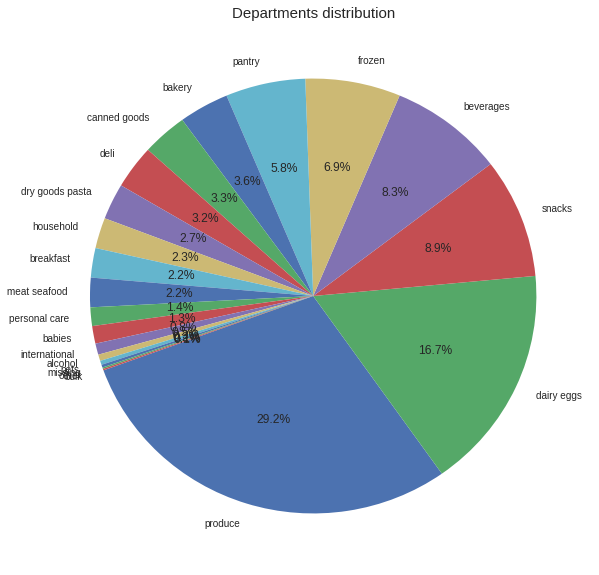

In [32]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

#plt.pieで円グラフの作成

Produceが最も多い部門になります。  


***部門 - 再購入比率***

再購入の対象となりやすい部門はどれでしょうか。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


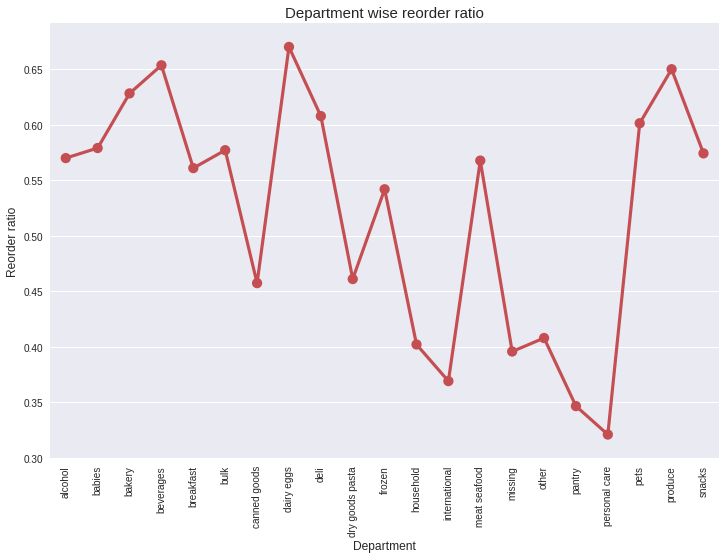

In [33]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

personal careが最も再購入されにくく、dairy eggsが最も再購入されています。

商品カテゴリ - 再購入比率

部門(department)と商品カテゴリ(aisle)を再購入比率で見ていきましょう。

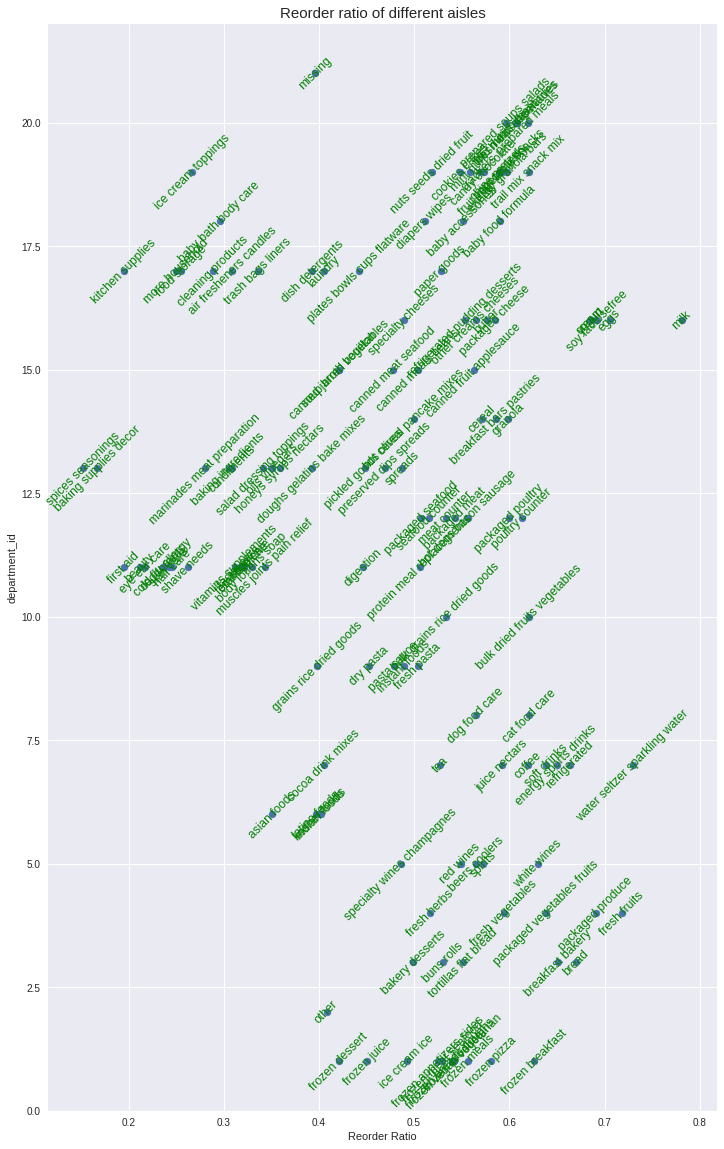

In [34]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

縦軸が部門、横軸は再購入比率です。同じ高さにある点は、同部門の別カテゴリ商品です。
これは見辛いですね。実際に利用するなら工夫が必要そう。

カートに入れる順番 - 再購入率

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


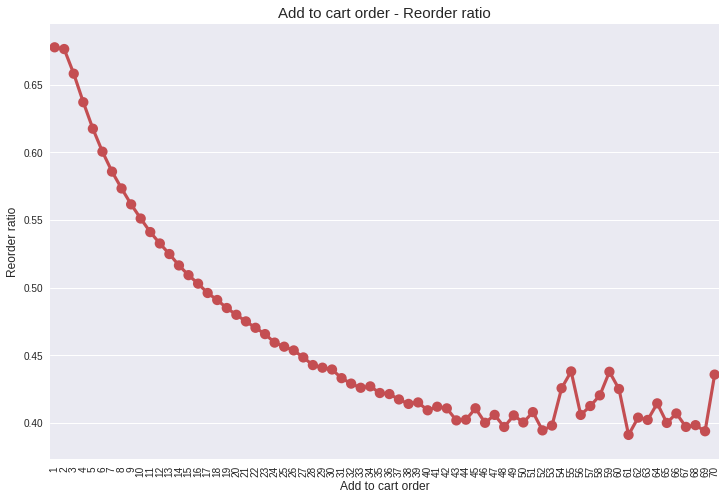

In [35]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].ix[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

当たり前と言えば当たり前ですが、最初の方にカートへ入れた商品ほど再購入しています。恒常的に購入する商品は先にカートへ入れているということがわかります。

時間 - 再購入率

曜日、1日の時間について、再購入率で見ていきましょう。

前に作成した3つのグラフを、reorderedの平均値を指標として作成します。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


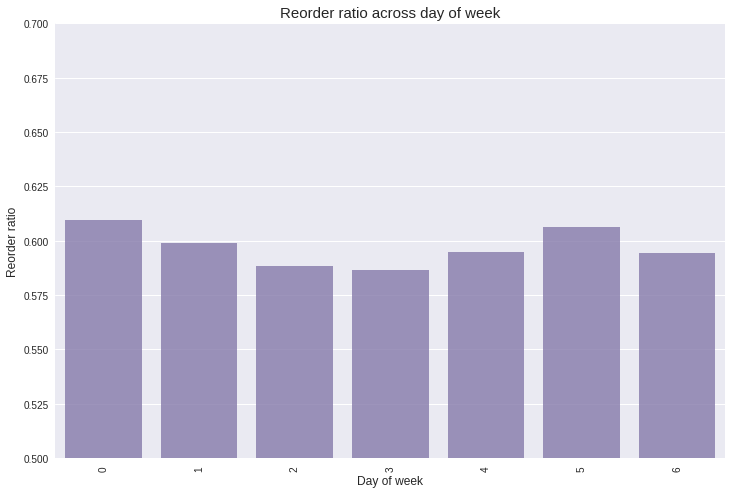

In [36]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

特定の曜日で再購入率が増減するわけではないようです。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


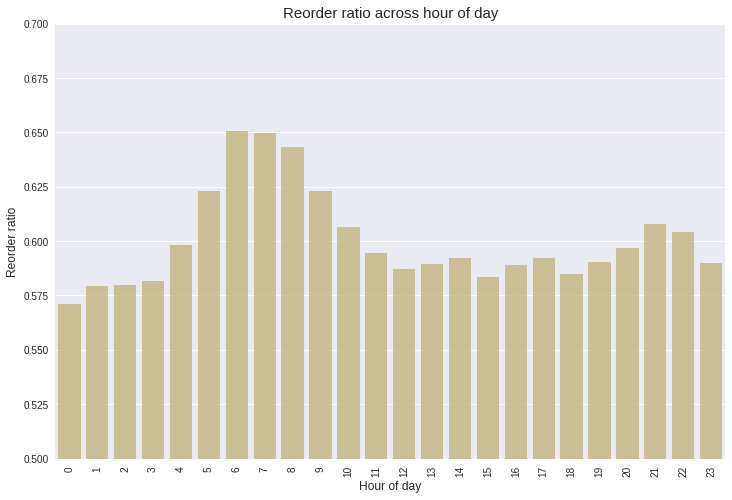

In [37]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

朝に注文した商品は、再購入である可能性が高いです。

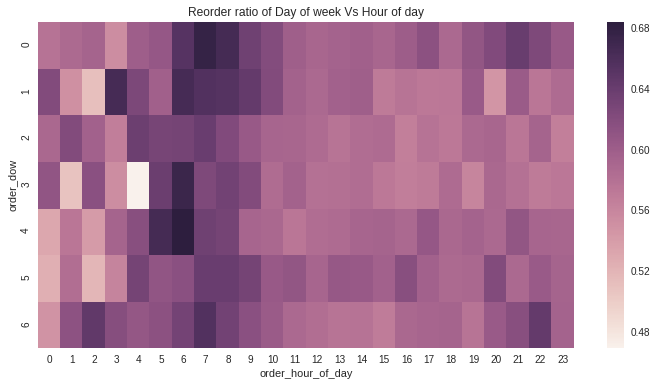

In [38]:

grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

全体的に朝の再購入率が高いです。週末の6-8時、火・水の5-6時が特に高くなっています。
以前のヒートマップでは、土日の午前午後に注文が多かったです。
しかし再購入という面で見ると、平日休日関係なく早朝に多いとわかりました。

